# Modules

In [86]:
using Pkg; Pkg.activate("."); 
using TSO
using PyPlot
using Profile

  Activating environment at `/cobra/u/peitner/Turbospectrum/opacity_tables/tests/Project.toml`


In [87]:
function get_cmap(binning; cmap="RdBu")
    min_c = minimum(binning)
    max_c = maximum(binning)
    d     = max_c - min_c + 1
    cmap  = plt.get_cmap(cmap, d)    # 11 discrete colors

    min_c, max_c, cmap
end;

# Load Tables

In [88]:
table_folder = joinpath("tables/TSO_AESOPUS_v2.3")
opacities    = reload(SqOpacity, joinpath(table_folder, "combined_opacities.hdf5"))
eos          = reload(SqEoS,     joinpath(table_folder, "combined_eos.hdf5"));

In [89]:
TSO.is_uniform(eos)

true

# Formation Height

In [90]:
model = Average3D(eos, "stagger_av.dat");

In [91]:
# Compute the optical depth scale + the formation height
τ_ross, τ_λ = optical_depth(eos, opacities, model)
d_ross, d_κ = formation_height(model, eos, opacities, τ_ross, τ_λ);

In [92]:
# Save the results
formation_opacities = SqOpacity(d_κ, d_ross, opacities.src, opacities.λ, true);

# Binning

In [93]:
weights = ω_midpoint(opacities);

In [94]:
bins_stagger = StaggerBinning(TSO.StaggerBins,                                                         
                            opacities=opacities, 
                            formation_opacity=-log10.(formation_opacities.κ_ross),  
                            Nbins=12, #κ_bins=4,
                            λ_low=3.6);

In [95]:
muram_edges = sort([99.00, 3.0, 1.5, 0.5, -99.00])
bins_muram  = MURaMBinning(bin_edges=muram_edges);

In [96]:
bin = binning(bins_muram, opacities, -log10.(formation_opacities.κ_ross));

In [97]:
binned_opacities     = tabulate(bin, weights, eos, opacities, transition_model=model);
binned_opacities_gen = tabulate(bin, weights, eos, opacities);

#binned_p, binned_r = tabulate(bin, weights, eos, opacities, remove_from_thin=false, transition_model=model);
#binned_opacities = binned_p;

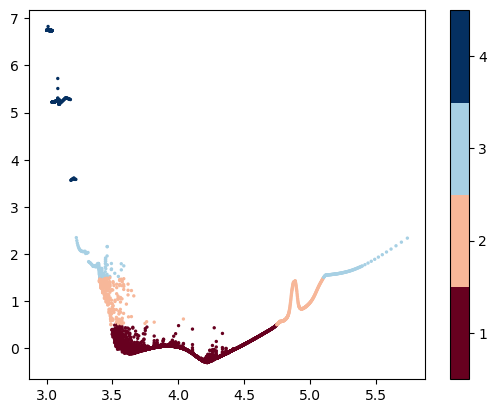

In [98]:
close()

min_c, max_c, cmap = get_cmap(bin)

plt.scatter(log10.(opacities.λ), -log10.(formation_opacities.κ_ross), c=bin, s=2, cmap=cmap, vmin=min_c-0.5, vmax=max_c+0.5)
plt.colorbar(ticks=collect(min_c:max_c))

gcf()

In [99]:
aos = @axed eos;

# Testing the binning

In [100]:
close()

f, ax = plt.subplots(4, 1, figsize=(9,9), sharex=true, sharey=true)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

ax = reshape(ax, :)

e, r = meshgrid(aos)

im = nothing
for i in eachindex(ax)
    im = ax[i].scatter(e, r, c=binned_opacities.wthin[:,:,i], s=0.1, vmin=0, vmax=1, cmap="rainbow")
    
    ## overplot the solar model
    ax[i].plot(model.lnT, model.lnρ, color="cyan", lw=4)

    ax[i].text(0.9, 0.1, "Bin $(i)", transform=ax[i].transAxes, va="bottom", ha="right", color="k", fontsize="large")
end
plt.colorbar(im, ax=ax)

f.text(0.5, 0.0, "ln Temp", ha="center", va="top")
f.text(0.0, 0.5, "ln ρ", va="center", ha="right", rotation="vertical")

gcf()

BoundsError: BoundsError: attempt to access 185×201×4 Array{Float32, 3} at index [1:185, 1:201, 5]

In [101]:
close()

f, ax = plt.subplots(4, 1, figsize=(9,9), sharex=true, sharey=true)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

ax = reshape(ax, :)

e, r = meshgrid(aos)

dbr = log10.(binned_opacities.opacities.κ) .- log10.(binned_opacities_gen.opacities.κ)#.- binned_r.opacities.κ)

vmin = minimum(dbr)
vmax = maximum(dbr)

im = nothing
for i in eachindex(ax)
    im = ax[i].scatter(e, r, c=dbr[:,:,i], s=0.1, vmin=vmin, vmax=vmax, cmap="rainbow")
    
    ## overplot the solar model
    ax[i].plot(model.lnT, model.lnρ, color="cyan", lw=4)

    ax[i].text(0.9, 0.1, "Bin $(i)", transform=ax[i].transAxes, va="bottom", ha="right", color="k", fontsize="large")
end
cb = plt.colorbar(im, ax=ax)
cb.set_label(L"\log_{10}(\kappa_{Ludwig}) - \log_{10}(\kappa_{Tabgen})")

f.text(0.5, 0.0, "ln Temp", ha="center", va="top")
f.text(0.0, 0.5, "ln ρ", va="center", ha="right", rotation="vertical")

gcf()

BoundsError: BoundsError: attempt to access 185×201×4 Array{Float32, 3} at index [1:185, 1:201, 5]

# Resampling and Switching from T to E

In [107]:
if !TSO.is_internal_energy(aos)
    @info "Converting Binned EoS to lnEi grid"
    eos_e, opacities_e = switch_energy(aos, binned_opacities; upsample=3000)

    # Make a version with the TSO EoS
    eosTS      = reload(SqEoS, "TSO_sun_Magg_v10.2/eos.hdf5")
    aosTS_up   = @axed upsample(eosTS, :lnEi, 1000)
    opa_regrid = complement(aos, aosTS_up, binned_opacities)
    transfer_rosseland!(opa_regrid.opacities, aosTS_up.eos);

    eosLEG    = reload(TSO.SqEoS, "/u/peitner/Turbospectrum/stagger_eos/legacy2squaregas/eos_sun_legacy.hdf5")
    aosLEG_up = @axed upsample(eosLEG, :lnEi, 2000)
    opa_LEG   = complement(aos, aosLEG_up, binned_opacities)
    transfer_rosseland!(opa_LEG.opacities, aosLEG_up.eos);
end;

┌ Info: Converting Binned EoS to lnEi grid
└ @ Main /u/peitner/Turbospectrum/opacity_tables/tests/bin_aesopus.ipynb:2


In [110]:
test_t = model.lnT
test_r = model.lnρ
aos_e  = @axed eos_e

test_e    = lookup(aos_e,    :lnEi, test_r, test_t)
test_eTS  = lookup(aosTS_up, :lnEi, test_r, test_t)
test_eLE  = lookup(aosLEG_up, :lnEi, test_r, test_t)
k_tgrid   = [lookup(aos,      binned_opacities.opacities, :κ, test_r, test_t,   i) for i in eachindex(binned_opacities.opacities.λ)]
k_egrid   = [lookup(aos_e,    opacities_e.opacities,      :κ, test_r, test_e,   i) for i in eachindex(binned_opacities.opacities.λ)]
k_egridTS = [lookup(aosTS_up, opa_regrid.opacities,       :κ, test_r, test_eTS, i) for i in eachindex(binned_opacities.opacities.λ)]
k_egridLE = [lookup(aosLEG_up, opa_LEG.opacities,       :κ, test_r, test_eLE, i) for i in eachindex(binned_opacities.opacities.λ)];

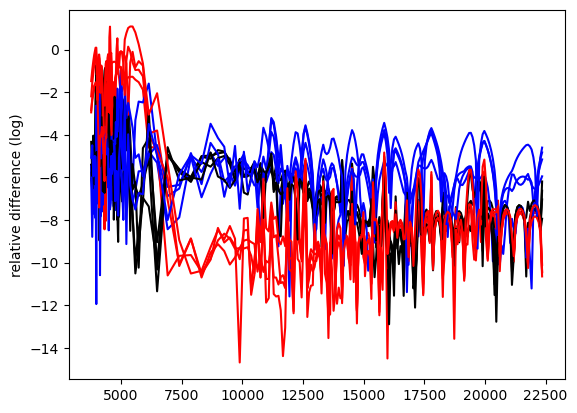

In [111]:
close()

for i in eachindex(binned_opacities.opacities.λ)
    plt.plot(exp.(test_t), log.(abs.( (k_tgrid[i] .- k_egridTS[i]) ./ k_tgrid[i] )), color="k")
    plt.plot(exp.(test_t), log.(abs.( (k_tgrid[i] .- k_egridLE[i]) ./ k_tgrid[i] )), color="b")
    plt.plot(exp.(test_t), log.(abs.( (k_tgrid[i] .- k_egrid[i]) ./ k_tgrid[i] )), color="r")
end

#plt.legend(ncol=7, bbox_to_anchor=(0.5, 1), loc="lower center")
plt.ylabel("relative difference (log)")

gcf()

# Save

In [112]:
function save_tables(aos, opa, eos_table_name)
    # Save everything in the dispatch format
    for_dispatch(aos, opa)
    save(opa.opacities, "binned_opacities.hdf5")

    # Move files to the final folder for dispatch
    !isdir(eos_table_name) && mkdir(eos_table_name) 
    mv("tabparam.in",           joinpath(eos_table_name, "tabparam.in"),           force=true)
    mv("eostable.dat",          joinpath(eos_table_name, "eostable.dat"),          force=true)
    mv("rhoei_radtab.dat",      joinpath(eos_table_name, "rhoei_radtab.dat"),      force=true)
    mv("binned_opacities.hdf5", joinpath(eos_table_name, "binned_opacities.hdf5"), force=true)

    # Copy the eos for convenience. Usually not a big deal because rather small
    cp(joinpath(table_folder, "combined_eos.hdf5"), joinpath(eos_table_name, "eos.hdf5"), force=true);
end

save_tables (generic function with 1 method)

In [113]:
#save_tables(@axed(eos_e), opacities_e, "DIS_AESOPUS_v1.3.1") # AESOPUS EoS from binned T
save_tables(aosTS_up,     opa_regrid,  "DIS_AESOPUS_v2.3.2") # TS EoS
#save_tables(aosLEG_up, opa_LEG, "DIS_AESOPUS_v1.3.3") # LEG EoS

"DIS_AESOPUS_v2.3.2/eos.hdf5"